# Inferring demo for AlloyGPT

## Goal:
> - [ ] Due to license restriction of Thermo-Calc, you will be asked for "dataset_key" to access the dataset and "model_key" to the trained model.
> - [ ] General user needs have access to Thermo-Calc to build the dataset and train their model.

## Ref:
> - 1. 

#### Bo Ni, Feb 18, 2025

## 1. Check the environment

In [1]:

import os, sys
# print('Here is : \n', os.popen('pwd').read())
# print('What we get in hardware: \n', os.popen('nvidia-smi').read())

kernel_name = os.path.basename(sys.executable.replace("/bin/python",""))
print ("The VirEnv kernal in action: ", kernel_name)
# #
# # # make it work for both py and notebook
# # try:
# #     from jupyter_client import kernelspec
# #     spec = kernelspec.get_kernel_spec(kernel_name)
# #     print("Path to it: ", spec.resource_dir)
# # except:
# #     print ("This suppose to be a .py run")
# # # /path/to/my/kernel

import torch
print("What we have in software: \n Torch version:", torch.__version__)
print('Python: ', sys.version) # no switch case code
#
print('What hardware the software see:')
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
print(device)
num_of_gpus = torch.cuda.device_count()
print("# of GPU", num_of_gpus)
#
torch.cuda.empty_cache()

The VirEnv kernal in action:  4_JuPy_LongSeq
What we have in software: 
 Torch version: 2.2.0+cu121
Python:  3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
What hardware the software see:
cuda:0
# of GPU 1


## 2. Configurate the task

In [2]:
# for debug
import importlib

In [3]:
import AlloyGPT.UtilityPack as UtilityPack
importlib.reload(UtilityPack)
#
import AlloyGPT.DataPack as DataPack
importlib.reload(DataPack)
#
import AlloyGPT.ModelPack as ModelPack
importlib.reload(ModelPack)
#
import AlloyGPT.TrainPack as TrainPack
importlib.reload(TrainPack)
#
import AlloyGPT.TestPack as TestPack
importlib.reload(TestPack)


<module 'AlloyGPT.TestPack' from '/trace/group/tmousavi/bni2/1_JupyterGit/workspace/AlloyGPT_InternalTest_0/AlloyGPT/TestPack.py'>

In [4]:
# load in
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import pandas as pd
# ++
import numpy as np
import getpass

In [5]:
# 

model_key = getpass.getpass(
    prompt="Please enter your key to the pretained model: \n\n"
)

Please enter your key to the pretained model: 

 ········


In [6]:
# ===============================================
# Global control key setup: may into yaml file
# ===============================================
# control key to be shared everywhere
#
CKeys = {}
CKeys['Working_Mode'] = 3 # 1 # 0 # 1 # 2
# 0: prepare dataset: run only on single node
# 1: training,
# 2: testing
# 3: testing remote one
CKeys['test_mode_level'] = 2 # 1, 2
# 1: on testset preparation
# 2: 5.3 make plots

# only for restart of training part
CKeys['IF_FirstRun'] = 2 # 1 # 2
CKeys['Resume_from_where'] = 'LAST'
# 1: train for 1st run; 2: other training loop

CKeys['Problem_ID'] = 6
# 1: Transformer-based causal LM: GPT2
# 2: Mamba-based causal LM
# 3: T-based causal LM + HF dataset on AlloyLan
# 4: selfmade S6
# 5: BPE tokenizer + hf-S6
# 6: BPE tokenizer + GPT2

# where to pick up the checkpoint
# CKeys['Resume_from_where'] = "LAST" # "BEST"
# as we are testing models, here we use the BEST
CKeys['Resume_from_where'] = "BEST"

# On Debug
# CKeys['Debug']=1
CKeys['Debug']=0

if CKeys['Debug'] == 1:
    CKeys['Debug_Data'] = 1
    CKeys['Debug_Model'] = 1
    CKeys['Debug_Train'] = 1
    CKeys['Debug_Test'] = 1
    # for On cluster run
    CKeys['if_slient_run']=0
else:
    CKeys['Debug_Data']=0
    CKeys['Debug_Model']=0
    CKeys['Debug_Train']=0
    CKeys['Debug_Test']=0
    # for On cluster run
    CKeys['if_slient_run']=1

In [7]:
print ("Check CKeys: \n")
for this_key in CKeys.keys():
    print (f"{this_key}: {CKeys[this_key]}")

Check CKeys: 

Working_Mode: 3
test_mode_level: 2
IF_FirstRun: 2
Resume_from_where: BEST
Problem_ID: 6
Debug: 0
Debug_Data: 0
Debug_Model: 0
Debug_Train: 0
Debug_Test: 0
if_slient_run: 1


## 3. download the pretrained model

In [8]:
from huggingface_hub import snapshot_download


In [9]:

trained_model_dir='./resu'

if os.path.exists(trained_model_dir):
    print(f"Path already exits. Use Caution...")
else:
    print(f"Download the pretrained model...")
    print(f"Note, this only works if you have the access key.")
    #
    snapshot_download(
        repo_id="Bo-Ni/AlloyGPT",
        local_dir='./',
        repo_type="model",
        token=model_key,
    )

Path already exits. Use Caution...


In [10]:
# parameter key

PKeys={}
# 
PKeys['wk_path']='./resu/'
# 
PKeys['pk_data_pack']=PKeys['wk_path']+'/data_pack.pickle'
PKeys['pk_model_pack']=PKeys['wk_path']+'/model_pack.pickle'
PKeys['pk_train_pack']=PKeys['wk_path']+'/train_pack.pickle'

## 4. On dataset

In [11]:
from datasets import (
    load_dataset,
    load_from_disk,
    load_dataset_builder,
    get_dataset_split_names,
    DatasetDict,
)
from torch.utils.data.dataloader import DataLoader

In [12]:
# get from test mode
# 
print("==========================================")
print ('This is not a data-prepare run')
print ('Load back in the data packages...')
print("==========================================")


print (PKeys['pk_data_pack'])
with open(PKeys['pk_data_pack'], 'rb') as handle:
    # data_pack = pickle.load(handle)
    DataKeys = pickle.load(handle)

# on tokenizer
# ++
tokenizer  = DataPack.reload_tokenizer(
    DataKeys
)

# on dataloaders
train_dataloader = torch.load(DataKeys['data_dir']+'/train_dataloader.pt')
eval_dataloader = torch.load(DataKeys['data_dir']+'/eval_dataloader.pt')
test_dataloader = torch.load(DataKeys['data_dir']+'/test_dataloader.pt')

# something else:
sentence_dataset_dict_sepe = load_from_disk(
    DataKeys['data_dir']+'/sentence_dataset_dict_hf'
)

print ('Done.')

This is not a data-prepare run
Load back in the data packages...
./resu//data_pack.pickle
Done.


## 5. on model

In [13]:
print("==========================================")
print ('This is not the first run')
print ('Load back in the model packages...')
print("==========================================")
print (PKeys['pk_model_pack'])

with open(PKeys['pk_model_pack'], 'rb') as handle:
    # data_pack = pickle.load(handle)
    ModelKeys = pickle.load(handle)
# 
# unpack the model_args key
model_args = ModelKeys['model_args']
print ("model_args: \n", model_args)
# 
# From Trainer to know what parameters to load in
with open(PKeys['pk_train_pack'], 'rb') as handle:
    # data_pack = pickle.load(handle)
    TrainKeys = pickle.load(handle)
    

This is not the first run
Load back in the model packages...
./resu//model_pack.pickle
model_args: 
 {'vocab_size': 256, 'n_layer': 36, 'block_size': 1024, 'n_embd': 1024, 'n_head': 16, 'bias': False, 'dropout': 0.2}


In [14]:
# if CKeys['Resume_from_where'] == 'LAST':
#     ckpt_name = TrainKeys['out_dir_last']+'Last_ckpt.pt'
#     # ++
#     ckpt_info_txt = TrainKeys['out_dir_last']+'3_save_model_last.log'
# elif CKeys['Resume_from_where'] == 'BEST':
#     ckpt_name = TrainKeys['out_dir_best']+'Best_ckpt.pt'
#     # ++
#     ckpt_info_txt = TrainKeys['out_dir_best']+'3_save_model_best.log'

# use the best checkpoint
ckpt_name = TrainKeys['out_dir_best']+'Best_ckpt.pt'
# ++
ckpt_info_txt = TrainKeys['out_dir_best']+'3_save_model_best.log'
    
# 
# ++
# get info from ckpt_info_txt
ckpt_info_arr = np.loadtxt(ckpt_info_txt, delimiter=',', dtype=np.int32)
print (f"Load from: Epoch {ckpt_info_arr[0]}, batch step {ckpt_info_arr[1]}, accumulated updated step {ckpt_info_arr[2]}")

# 
# prepare to resume training from a checkpoint
checkpoint = torch.load(ckpt_name, map_location=TrainKeys['device'])
checkpoint_model_args = checkpoint['model_args']
# 
# force these config attributes to be equal otherwise we can't even resume training
# the rest of the attributes (e.g. dropout) can stay as desired from command line
# 
# For new models, this is just a check
# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
# problem-specified
for k in checkpoint_model_args.keys():
    if model_args[k] != checkpoint_model_args[k]:
        print ("hard update needed on ", k)
        print ("old: ", model_args[k])
        print ("new: ", checkpoint_model_args[k])
        model_args[k] = checkpoint_model_args[k]
print ("Updated model_args: ", model_args)


Load from: Epoch 4, batch step 377600, accumulated updated step 47200
Updated model_args:  {'vocab_size': 256, 'n_layer': 36, 'block_size': 1024, 'n_embd': 1024, 'n_head': 16, 'bias': False, 'dropout': 0.2}


In [15]:
print ("=========================================")
print ("Initialize the model from the scratch...")
print ("=========================================")
#
model_config = ModelPack.build_model_config(
    CKeys,
    model_args
)
# 
model = ModelPack.build_model(
    CKeys,
    model_config,
)

Initialize the model from the scratch...
number of parameters: 453.32M


In [16]:
# print (model)

In [17]:
print ("===================================================")
print ("Load back the model if this's not the 1st training.")
print ("===================================================")
# 
# Here, for GPT, we use checkpoint to load back the model
print ("Loading the saved model...")
# 
state_dict = checkpoint['model']
# NOTE, this one has unwanted contents.
# fix the keys of the state dictionary :(
# honestly no idea how checkpoints sometimes get this prefix, have to debug more
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
# 
# load back the previous breaking point
print ("Load in the model...")
model.load_state_dict(state_dict)
print ("Update some other recrods...")

print ("Done")

Load back the model if this's not the 1st training.
Loading the saved model...
Load in the model...
Update some other recrods...
Done


## 6. on testing

In [18]:
# load in
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

In [19]:
TestKeys = {
    'out_dir': PKeys['wk_path']+'/1_model/test_dir/',
    'num_samples': 2,
    'max_new_tokens': 1024,
    'temperature': 0.8,
    'top_k': 200,
    'seed': 1337,
    # 'device': 'cuda',
    'dtype': 'bfloat16',
    'compile': True
}

# for docker implementation
if torch.cuda.is_available():
    # 
    TestKeys['device']='cuda' # if device=='cuda:0' else 'cpu'
else:
    # 
    TestKeys['device']='cpu'


In [20]:
TestKeys['demo_dir'] = \
TestKeys['out_dir']+'demo_playground/'

# create the folder
UtilityPack.create_path(TestKeys['out_dir'])
UtilityPack.create_path(TestKeys['demo_dir'])

The given path already exists!
The given path already exists!


2

In [21]:
TestKeys, ctx = \
TrainPack.initialize_test_fun(TestKeys)

In [22]:
print ("==========================================")
print ("On generation...")
print ("==========================================")
model.eval()
model.to(TestKeys['device'])
if TestKeys['compile']:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

    print (f"Model structure:")
    print (model)
    


On generation...
Model structure:
OptimizedModule(
  (_orig_mod): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(256, 1024)
      (wpe): Embedding(1024, 1024)
      (drop): Dropout(p=0.2, inplace=False)
      (h): ModuleList(
        (0-35): 36 x MHA_Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=1024, out_features=3072, bias=False)
            (c_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (attn_dropout): Dropout(p=0.2, inplace=False)
            (resid_dropout): Dropout(p=0.2, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=False)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_he

### 6.1 on individual test

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as img

In [24]:
# parameters

df_key_list = [
    '(Al)', '(Ni)', '(Er)', '(Zr)', '(Y)', '(Yb)', 
    'AsBuilt_L12Mol%', 'AsBuilt_TernaryMol%',
    'AsBuilt_Al3NiMol%', 'AsBuilt_Al3ZrMol%',
    'L12Mol%', 'TernaryMol%','Al3NiMol%','Al3ZrMol%',
    'DiffusionResistivity', 'Misfit', 'CoarseningMetric', 
    'FreezingRange','CrackSusceptibilityCoefficient','HotCrackingSusceptibility',
]
# 
Forward_CtoSP_Keys = [
    # structure
    'AsBuilt_L12Mol%', 
    'AsBuilt_TernaryMol%', 
    'AsBuilt_Al3NiMol%', 
    'AsBuilt_Al3ZrMol%', 
    'L12Mol%', 
    'TernaryMol%', 
    'Al3NiMol%', 
    'Al3ZrMol%', 
    # properties
    'DiffusionResistivity', 
    'Misfit', 
    'CoarseningMetric', 
    'FreezingRange', 
    'CrackSusceptibilityCoefficient', 
    'HotCrackingSusceptibility',
]
# 
Forward_CStoP_Keys = [
    # properties
    'DiffusionResistivity', 
    'Misfit', 
    'CoarseningMetric', 
    'FreezingRange', 
    'CrackSusceptibilityCoefficient', 
    'HotCrackingSusceptibility',
]
# 
Inverse_PtoSC_Keys = [
    # structure
    'AsBuilt_L12Mol%', 
    'AsBuilt_TernaryMol%', 
    'AsBuilt_Al3NiMol%', 
    'AsBuilt_Al3ZrMol%', 
    'L12Mol%', 
    'TernaryMol%', 
    'Al3NiMol%', 
    'Al3ZrMol%',
    # Composition:[
    '(Al)', 
    '(Ni)', 
    '(Er)', 
    '(Zr)', 
    '(Y)', 
    '(Yb)',
]
# 
Inverse_PStoC_Keys = [
    # Composition:[
    '(Al)',
    '(Ni)',
    '(Er)',
    '(Zr)',
    '(Y)',
    '(Yb)',
]

# add some keys to be used at the test set
# 492 # 206 # 422 # 139
input_len_for_tasks = {}
input_len_for_tasks['CtoSP']=139 # 139
input_len_for_tasks['CStoP']=353 # 422
input_len_for_tasks['PtoSC']=223 # 206
input_len_for_tasks['PStoC']=440 # 492



In [25]:
# helper functions

def get_record_from_test_set(
    i_record,
    task_type,
    sentence_set_name='test', # default as 'test', can be 'train'
):
    full_record = None
    input_promp = None
    error_msg = None
    # 
    if task_type=='CtoSP' or task_type=='CStoP':
        sentence_set_name = 'Pred001_sentence'
    elif task_type=='PtoSC' or task_type=='PStoC':
        sentence_set_name = 'Gene001_sentence'
    else:
        error_msg = "Task type doesn't exists!"
        
        
    full_record = sentence_dataset_dict_sepe['test'][sentence_set_name][i_record]
    input_promp = full_record[:input_len_for_tasks[task_type]]
    
    return full_record, input_promp, error_msg

# ==================================================

# helper wrapping functions
# 
def pick_one_and_prepare_promps_Prediction(ii):
    
    full_rec = sentence_dataset_dict_sepe['test']['Pred001_sentence'][ii]
    CtoSP_pro = full_rec[:input_len_for_tasks['CtoSP']]
    CStoP_pro = full_rec[:input_len_for_tasks['CStoP']]
    
    return full_rec, CtoSP_pro, CStoP_pro
# 
def pred_CtoSP_and_CStoP_for_one_rec(
    CtoSP_pro,
    CStoP_pro,
):
    CtoSP_out = TrainPack.generate_single_example_AR_LM_w_token_tokenizer(
        ctx,
        model,
        tokenizer,
        CtoSP_pro,
        device=device,
        pred_num=1,
        max_new_tokens=536-len(CtoSP_pro), # 1024-len(input_prompt),
        pred_temp=1.,
        top_k=100,
    )
    
    CStoP_out = TrainPack.generate_single_example_AR_LM_w_token_tokenizer(
        ctx,
        model,
        tokenizer,
        CStoP_pro,
        device=device,
        pred_num=1,
        max_new_tokens=536-len(CStoP_pro), # 1024-len(input_prompt),
        pred_temp=1.,
        top_k=100,
    )
    
    return CtoSP_out[0], CStoP_out[0]
# 
def convert_dict_str_to_val(dic):
    dict_1 = dic.copy()
    for this_key in dict_1.keys():
        if this_key!='Task':
            dict_1[this_key] = float(dict_1[this_key])
    return dict_1

def plot_compare_bar_plots(
    sslabels,
    value_list_1,
    value_list_2,
    label_1,
    label_2,
    y_label,
    file_name,
    # 
    legend_loc='best'
):
    
    # sslabels = Forward_Short_Resu_Keys

    x=np.linspace (0, len(sslabels)-1, len(sslabels))

    # fig, ax = plt.subplots(1, 1)
    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    ax.bar(x-0.15, value_list_1, width=0.3, color='b', align='center')
    ax.bar(x+0.15, value_list_2, width=0.3, color='r', align='center')

    # ax.set_ylim([0, 1])

    plt.xticks(range(len(sslabels)), sslabels, size='medium', rotation=90)
    plt.legend ([label_1, label_2], loc=legend_loc)

    plt.ylabel (y_label)
    plt.savefig(file_name, bbox_inches='tight',dpi=100)
    # plt.show()
    plt.close()

    return file_name
    
def ana_CtoSP_vs_CStoP(
    gt,
    CtoSP_out,
    CStoP_out,
):
    full_key_list = df_key_list+['SafeRec']
    # 
    gt_dict = TestPack.covert_one_line_head_and_body(
        gt,
        df_key_list+['SafeRec']
    )
    gt_dict = convert_dict_str_to_val(gt_dict)
    # 
    CtoSP_dict = TestPack.covert_one_line_head_and_body(
        CtoSP_out,
        df_key_list+['SafeRec']
    )
    CStoP_dict = TestPack.covert_one_line_head_and_body(
        CStoP_out,
        df_key_list+['SafeRec']
    )
    assert CtoSP_dict['SafeRec']=='1', 'Unreadable records'
    assert CStoP_dict['SafeRec']=='1', 'Unreadable records'
    
    CtoSP_dict = convert_dict_str_to_val(CtoSP_dict)
    CStoP_dict = convert_dict_str_to_val(CStoP_dict)
    
    # L1 error
    L1_error_list = np.zeros((2, len(Forward_CtoSP_Keys)))
    # for CtoSP
    for ii, this_key in enumerate(Forward_CtoSP_Keys):
        L1_error_list[0,ii] = np.fabs(CtoSP_dict[this_key]-gt_dict[this_key])
    # for CStoP
    for ii, this_key in enumerate(Forward_CtoSP_Keys):
        if this_key in Forward_CStoP_Keys:
            L1_error_list[1,ii]=np.fabs(CStoP_dict[this_key]-gt_dict[this_key])
    
    # drow 
    
    
    
    return L1_error_list
# 
def plot_CtoSP_CStoP(
    gt,
    CtoSP_out,
    CStoP_out,
    file_name=TestKeys['demo_dir']+'/L1_CtoSP_CStoP.png'
):
    L1_error_list=ana_CtoSP_vs_CStoP(
        gt,
        CtoSP_out,
        CStoP_out,
    )

    plot_compare_bar_plots(
        sslabels=Forward_CtoSP_Keys,
        value_list_1=L1_error_list[0,:],
        value_list_2=L1_error_list[1,:],
        label_1='CtoSP',
        label_2='CStoP',
        y_label='L1 error',
        file_name=file_name
    )
    return file_name

# for Tab C
# =======================================================
def pick_one_and_prepare_promps_Design_PtoSC(ii):
    
    full_rec = sentence_dataset_dict_sepe['test']['Gene001_sentence'][ii]
    PtoSC_pro = full_rec[:input_len_for_tasks['PtoSC']]
    PStoC_pro = full_rec[:input_len_for_tasks['PStoC']]
    
    return full_rec, PtoSC_pro # , CStoP_pro
# 

def pred_PtoSC_for_one_rec_twice(
    PtoSC_pro,
    pred_t,
):
    PtoSC_out = TrainPack.generate_single_example_AR_LM_w_token_tokenizer(
        ctx,
        model,
        tokenizer,
        PtoSC_pro,
        device=device,
        pred_num=2,
        max_new_tokens=536-len(PtoSC_pro), # 1024-len(input_prompt),
        pred_temp=pred_t,
        top_k=100,
    )
    
    return PtoSC_out[0], PtoSC_out[1]

# =================================================================
# 
def plot_three_bar_plots(
    sslabels,
    value_list_1, # gt
    value_list_2,
    value_list_3,
    label_1,
    label_2,
    label_3,
    y_label,
    file_name,
    # 
    legend_loc='best'
):
    
    # sslabels = Forward_Short_Resu_Keys

    x=np.linspace (0, len(sslabels)-1, len(sslabels))

    # fig, ax = plt.subplots(1, 1)
    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    dX = 0.15
    ax.bar(x-dX*2, value_list_1, width=2*dX, color='r', align='center')
    ax.bar(x,      value_list_2, width=2*dX, color='b', align='center')
    ax.bar(x+dX*2, value_list_3, width=2*dX, color='g', align='center')

    # ax.set_ylim([0, 1])

    plt.xticks(range(len(sslabels)), sslabels, size='medium', rotation=90)
    plt.legend ([label_1, label_2, label_3], loc=legend_loc)

    plt.ylabel (y_label)
    plt.savefig(file_name, bbox_inches='tight',dpi=100)
    # plt.show()
    plt.close()

    return file_name
    
def get_vals_for_keys_in_dict(
    this_dict,
    key_list,
):
    val_list = []
    for this_key in key_list:
        val_list.append(this_dict[this_key])
    return val_list
    
def plot_comp_for_PtoSC_1_2_and_FR(
    gt,
    PtoSC_out_1,
    PtoSC_out_2,
    # 
    file_name=TestKeys['demo_dir']+'/Comp_PtoSC_1_2_FR.png'
):
    full_key_list = df_key_list+['SafeRec']
    # 
    gt_dict = TestPack.covert_one_line_head_and_body(
        gt,
        df_key_list+['SafeRec']
    )
    gt_dict = convert_dict_str_to_val(gt_dict)
    # 
    
    PtoSC_dict_1 = TestPack.covert_one_line_head_and_body(
        PtoSC_out_1,
        df_key_list+['SafeRec']
    )
    PtoSC_dict_2 = TestPack.covert_one_line_head_and_body(
        PtoSC_out_2,
        df_key_list+['SafeRec']
    )
    assert PtoSC_dict_1['SafeRec']=='1', 'Unreadable records'
    assert PtoSC_dict_2['SafeRec']=='1', 'Unreadable records'
    
    PtoSC_dict_1 = convert_dict_str_to_val(PtoSC_dict_1)
    PtoSC_dict_2 = convert_dict_str_to_val(PtoSC_dict_2)

    plot_keys = ['(Ni)', '(Er)', '(Zr)', '(Y)', '(Yb)']

    val_list_1 = get_vals_for_keys_in_dict(
        this_dict=gt_dict,
        key_list=plot_keys,
    )
    val_list_2 = get_vals_for_keys_in_dict(
        this_dict=PtoSC_dict_1,
        key_list=plot_keys,
    )
    val_list_3 = get_vals_for_keys_in_dict(
        this_dict=PtoSC_dict_2,
        key_list=plot_keys,
    )


    # make the plot
    plot_three_bar_plots(
        sslabels=plot_keys,
        value_list_1=val_list_1, # gt
        value_list_2=val_list_2,
        value_list_3=val_list_3,
        label_1='Known case',
        label_2='Design 1',
        label_3='Design 2',
        y_label='Mol%',
        file_name=file_name,
        # 
        legend_loc='best'
    )

    return file_name

In [26]:
from termcolor import colored

### Forward prediction

In [27]:
print (f"In this demo, we focus on forward prediction and compare CtoSP and CStoP...\n")

i_pick = 11
print (f"Pick {i_pick}th record from the test set...\n")

t_full_rec, t_CtoSP_pro, t_CStoP_pro= \
pick_one_and_prepare_promps_Prediction(
   ii=i_pick,
)
print (f"The input prompt for CtoSP is \n{colored(t_CtoSP_pro, 'blue')}\n")
print (f"The input prompt for CStoP is \n{colored(t_CStoP_pro, 'blue')}\n")

t_CtoSP_out, t_CStoP_out = \
pred_CtoSP_and_CStoP_for_one_rec(
    t_CtoSP_pro,
    t_CStoP_pro,
)
print (f"CtoSP prediction:\n")
print (
    colored(t_CtoSP_out[:input_len_for_tasks['CtoSP']], 'blue')+\
    colored(t_CtoSP_out[input_len_for_tasks['CtoSP']:], 'red'),
)
print ()
print (f"CStoP prediction:\n")
print (
    colored(t_CStoP_out[:input_len_for_tasks['CStoP']], 'blue')+\
    colored(t_CStoP_out[input_len_for_tasks['CStoP']:], 'red'),
)
print ()



In this demo, we focus on forward prediction and compare CtoSP and CStoP...

Pick 11th record from the test set...

The input prompt for CtoSP is 
{Task:Pred001}={Composition:[(Al):+9.595e+01,(Ni):+6.830e-01,(Er):+1.874e+00,(Zr):+6.268e-01,(Y):+2.451e-02,(Yb):+8.439e-01]}=>{Structure:[

The input prompt for CStoP is 
{Task:Pred001}={Composition:[(Al):+9.595e+01,(Ni):+6.830e-01,(Er):+1.874e+00,(Zr):+6.268e-01,(Y):+2.451e-02,(Yb):+8.439e-01]}=>{Structure:[AsBuilt_L12Mol%:+1.335e+01,AsBuilt_TernaryMol%:+2.546e-01,AsBuilt_Al3NiMol%:+2.266e+00,AsBuilt_Al3ZrMol%:+0.000e+00,L12Mol%:+1.348e+01,TernaryMol%:+0.000e+00,Al3NiMol%:+2.722e+00,Al3ZrMol%:+0.000e+00]}=>{Property:[

CtoSP prediction:

{Task:Pred001}={Composition:[(Al):+9.595e+01,(Ni):+6.830e-01,(Er):+1.874e+00,(Zr):+6.268e-01,(Y):+2.451e-02,(Yb):+8.439e-01]}=>{Structure:[AsBuilt_L12Mol%:+1.277e+01,AsBuilt_TernaryMol%:+5.124e-01,AsBuilt_Al3NiMol%:+1.867e+00,AsBuilt_Al3ZrMol%:+0.000e+00,L12Mol%:+1.321e+01,TernaryMol%:+0.000e+00,Al3NiMol%:

### Inverse deisgn

In this demo, we focus on P-to-SC designs...

Pick 10th record from the test set...

The input prompt is 
{Task:Gene001}={Property:[DiffusionResistivity:+8.984e-01,Misfit:+1.037e+00,CoarseningMetric:+1.155e+00,FreezingRange:+2.343e-01,CrackSusceptibilityCoefficient:+1.860e-01,HotCrackingSusceptibility:+4.357e-02]}=>{Structure:[

We apply AlloyGPT to complete the sentence twice...

1st generation:

{Task:Gene001}={Property:[DiffusionResistivity:+8.984e-01,Misfit:+1.037e+00,CoarseningMetric:+1.155e+00,FreezingRange:+2.343e-01,CrackSusceptibilityCoefficient:+1.860e-01,HotCrackingSusceptibility:+4.357e-02]}=>{Structure:[AsBuilt_L12Mol%:+1.220e+01,AsBuilt_TernaryMol%:+4.965e+00,AsBuilt_Al3NiMol%:+0.000e+00,AsBuilt_Al3ZrMol%:+1.667e-02,L12Mol%:+1.471e+01,TernaryMol%:+0.000e+00,Al3NiMol%:+3.881e+00,Al3ZrMol%:+0.000e+00]}=>{Composition:[(Al):+9.564e+01,(Ni):+9.726e-01,(Er):+1.956e+00,(Zr):+1.079e+00,(Y):+3.318e-01,(Yb):+1.182e-01]}

2nd generation:

{Task:Gene001}={Property:[DiffusionResistivi

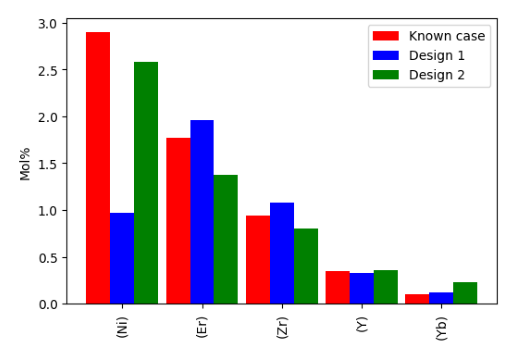

Note that, you will need Thermo-Calc to check the design accuracy.


In [28]:
# print (len(sentence_dataset_dict_sepe['test']['Gene001_sentence']))
print (f"In this demo, we focus on P-to-SC designs...\n")

i_pick = 10
print (f"Pick {i_pick}th record from the test set...\n")

t_full_rec, t_PtoSC_pro = \
pick_one_and_prepare_promps_Design_PtoSC(
    ii=i_pick
)
print (f"The input prompt is \n{colored(t_PtoSC_pro, 'blue')}\n")

print (f"We apply AlloyGPT to complete the sentence twice...\n")
t_PtoSC_out_1, t_PtoSC_out_2 = \
pred_PtoSC_for_one_rec_twice(
    t_PtoSC_pro,
    pred_t=1.0
)

print (f"1st generation:\n")
print (
    colored(t_PtoSC_out_1[:input_len_for_tasks['PtoSC']], 'blue')+\
    colored(t_PtoSC_out_1[input_len_for_tasks['PtoSC']:], 'red'),
)
print ()
print (f"2nd generation:\n")
print (
    colored(t_PtoSC_out_2[:input_len_for_tasks['PtoSC']], 'blue')+\
    colored(t_PtoSC_out_2[input_len_for_tasks['PtoSC']:], 'red'),
)
print ()

print (f"Compare the two designs with the ground truth...\n")
# 
t_pic = plot_comp_for_PtoSC_1_2_and_FR(
    gt=t_full_rec,
    PtoSC_out_1=t_PtoSC_out_1,
    PtoSC_out_2=t_PtoSC_out_2,
    # 
    file_name=TestKeys['demo_dir']+'/L1_PtoSC_1_2_FR.png'
)

# Read the PNG image file
image = img.imread(TestKeys['demo_dir']+'/L1_PtoSC_1_2_FR.png')

# Display the image
plt.imshow(image)
plt.gca().set_axis_off()
plt.show()
# print (t_full_rec, '\n\n', t_PtoSC_pro)
plt.close()

print (f"Note that, you will need Thermo-Calc to check the design accuracy.")